# General dependencies

In [61]:
import os
import tarfile
import urllib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Prepare the train and test sets

### Downloads and decompress the dataset

In [13]:
#import os
#import tarfile
#import urllib

#where the data is
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"

HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    '''This function creates the dir, downloads the .tar and decompress it'''
    
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
    
fetch_housing_data()

### Read the csv as a DataFrame

In [14]:
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [15]:
#More info about the dataframe
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


**The dataframe has 20640 entries, 10 columns <br>
9 of those features are numeric ones, while ocean_proximity is not <br>
total_bedrooms have some null values**

In [16]:
#What kind of data ocean_proximity stores?
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

**ocean_proximity is a categoric feature, it contains strings (treated as objects)**

In [17]:
#some more info
housing.describe() #only for numeric features

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


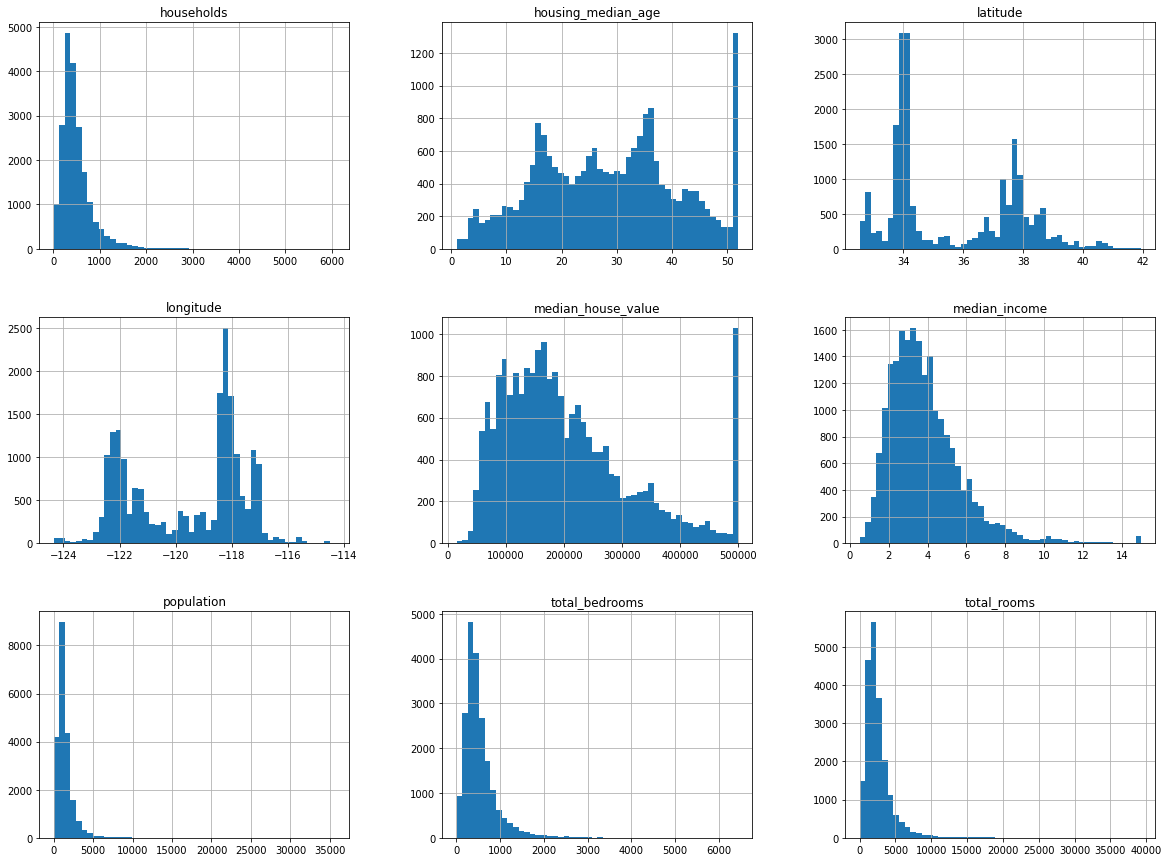

In [18]:
#Let's see the data we are going to work with

%matplotlib inline   
housing.hist(bins=50, figsize=(20,15))
plt.show()

**Befor proceding to develop any system, we need to split the data in train and test sets.
Usually, aorund 20% of the data is used for testing the system performance.
A simple solution would be to randomly pick instances for the test set and remove them from the training one.
The problem with this solution is that the instances in the train set change every time the system is run. All instances will be part of the training set eventually.
A solution to this issue would be to manually set a seed at the random process, but if more data is added to the dataset, it will change its behavior.**

**We need a decision rule that doesn't change regardless the data has changed. For doing this, we need a unique identifier for each row, for example an index.
Then we can make a hash function to map that index to a "train" or "test" value.
For example, we could generate a function that takes the index, keeps the last byte and compare if it's below a threshold. (For 256 bits, the 20% would be 51, any byte below 51 would be a test entry.)**
```
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]
    

test_ratio = 0.2
housing_with_id = housing.reset_index()   # adds an `index` column
train_set, test_set = split_train_test_by_id(housing_with_id, test_ratio, "index")
    
```

**The only weak spot here is that, in order to maintein the index inmutable, new data has to be append at the end of the file. An it's vulnerable to row deletions. A more robust approach would be to generate an identifier from other features:**

```
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
```

In [19]:
#Instead of defining our own function, we can use one from sklearn
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
#housing_with_id = housing.reset_index()
#train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

**Be aware of bias. Randomly split the dataset works for a lot of cases, but if a category is important, the sets should maintein the original distribution**

<AxesSubplot:>

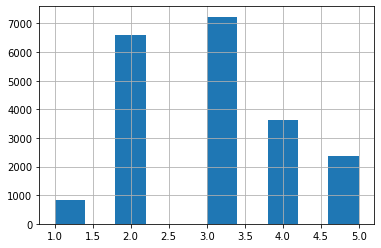

In [21]:
#The median income is important, we split the variable into five clusters:
#0-1.5; 1.5-3.0; 3.0-4.5; 4.5-6; 6-inf
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])
housing["income_cat"].hist()

**Since this is a really important feature, we want to keep its distribution in the training set**

In [22]:
# the second and third clusters enclose around 2/3 of the dataset, the sets should copy this

from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]


In [38]:
#Let's compare

original = housing["income_cat"].value_counts() / len(housing)
train = strat_train_set["income_cat"].value_counts() / len(strat_train_set)
test = strat_test_set["income_cat"].value_counts() / len(strat_test_set)

for i in range(1, 6):
    print('{}: '.format(i), original[i], train[i], test[i], sep='\t')

1: 	0.039825581395348836	0.03984980620155039	0.03972868217054264
2: 	0.3188468992248062	0.318859011627907	0.3187984496124031
3: 	0.3505813953488372	0.350593507751938	0.3505329457364341
4: 	0.17630813953488372	0.17629602713178294	0.17635658914728683
5: 	0.11443798449612404	0.1144016472868217	0.11458333333333333


**This is better.<br>
Now the income_cat is no longer needed. We can to drop it.<br>
From now on, we are not going to touch the test set, we are going to wait until the model is complete.**

In [39]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

# Data visualization

**Work with the train set, if it is large, create a subset to work faster**

In [40]:
housing = strat_train_set.copy()    #copy to get work done without messing with it 

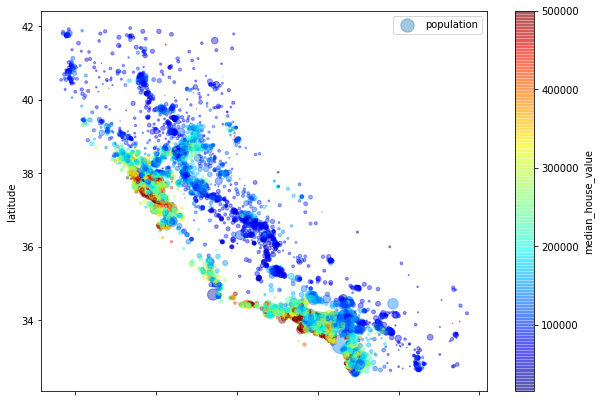

In [41]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
)
plt.legend()

value vs location? 

# Correlations

**Since the train set is not large enough, it is possible to calculate each variable (column) correlation.**
**will use the standard correlation coefficient**

In [44]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

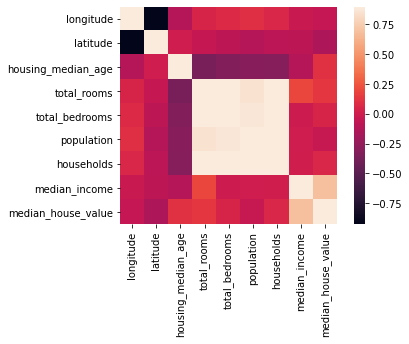

In [45]:
import seaborn as sns
sns.heatmap(corr_matrix, vmax=0.9, square=True)
plt.show();

<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>

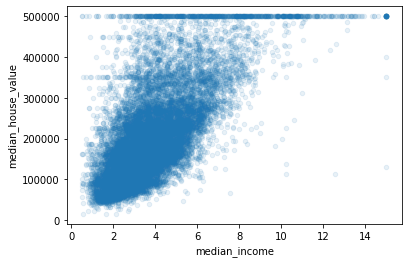

In [46]:
#Since median_income is by far the most correlated variable, let's take a look more closely
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)

In [25]:
#more variables to analize 
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

# Clean data

In [67]:
housing = strat_train_set.drop("median_house_value", axis=1) #input
housing_labels = strat_train_set["median_house_value"].copy() #desired output

### What about the missing data?

#### There are three options:
    1. Get rid of the row
    2. Get rid of the whole attribute
    3. Set a value (zero, mean, median, etc.)

In [47]:
#In this case, the only field that has empty data is the "total_bedrooms" one:
housing.dropna(subset=["total_bedrooms"])    # option 1

housing.drop("total_bedrooms", axis=1)       # option 2

median = housing["total_bedrooms"].median()  # option 3
housing["total_bedrooms"].fillna(median, inplace=True)

##### What if there are more atributes with incongruences?

In [68]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

#drop all non numeric attributes
housing_num = housing.drop("ocean_proximity", axis=1)
imputer.fit(housing_num)

imputer.statistics_ == housing_num.median().values #the medians are saved in the statistics_ attb


array([ True,  True,  True,  True,  True,  True,  True,  True])

# IMPORTANT! The values have to be taken from the train set, even the test set has to be completed with this values

In [50]:
#change all the incomplete values by its corresponding median
X = imputer.transform(housing_num) #it's a np Array

#to make it a Data Frame:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)


### What about the non numerical fields?

In [51]:
housing_cat = housing["ocean_proximity"]
housing_cat.head(10)

17606     <1H OCEAN
18632     <1H OCEAN
14650    NEAR OCEAN
3230         INLAND
3555      <1H OCEAN
19480        INLAND
8879      <1H OCEAN
13685        INLAND
4937      <1H OCEAN
4861      <1H OCEAN
Name: ocean_proximity, dtype: object

#### It’s not arbitrary text: there are a limited number of possible values, each of which represents a category. So this attribute is a categorical attribute. We can convert this values into numbers 

In [70]:
from sklearn.preprocessing import LabelEncoder

ordinal_encoder = LabelEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([0, 0, 4, 1, 0, 1, 0, 1, 0, 0])

## Wait! 
#### In this case some algorithms may think that two nearby values are more similar than two distant values.  This may be fine in some cases (e.g., for ordered categories such as “bad,” “average,” “good,” and “excellent”).
#### To fix this issue, a common solution is to create one binary attribute per category: one attribute equal to 1 when the category is “<1H OCEAN” (and 0 otherwise), another attribute equal to 1 when the category is “INLAND” (and 0 otherwise), and so on. This is called one-hot encoding, because only one attribute will be equal to 1 (hot), while the others will be 0 (cold). The new attributes are sometimes called dummy attributes. 

In [71]:
#from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer

cat_encoder = LabelBinarizer()
#housing_cat_1hot = cat_encoder.fit_transform(housing_cat_encoded.reshape(-1,1))
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
#housing_cat_1hot.toarray()
housing_cat_1hot

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       ...,
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0]])

### What if I have to create my own transformer?
#### You will want your transformer to work seamlessly with Scikit-Learn functionalities (such as pipelines), and since Scikit-Learn relies on duck typing (not inheritance), all you need to do is create a class and implement three methods: fit() (returning self), transform(), and fit_transform().

In [72]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]

        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

#### In this example the transformer has one hyperparameter, add_bedrooms_per_room, set to True by default (it is often helpful to provide sensible defaults). This hyperparameter will allow you to easily find out whether adding this attribute helps the Machine Learning algorithms or not. More generally, you can add a hyperparameter to gate any data preparation step that you are not 100% sure about. The more you automate these data preparation steps, the more combinations you can automatically try out, making it much more likely that you will find a great combination (and saving you a lot of time).

# Feature Scaling
**One of the most important transformations you need to apply to your data is feature scaling. With few exceptions, Machine Learning algorithms don’t perform well when the input numerical attributes have very different scales.
There are two common ways to get all attributes to have the same scale: min-max scaling and standardization. <br>
Min-max scaling (many people call this normalization): values are shifted and rescaled so that they end up ranging from 0 to 1. <br>
Standardization is different: first it subtracts the mean value (so standardized values always have a zero mean), and then it divides by the standard deviation so that the resulting distribution has unit variance. Unlike min-max scaling, standardization does not bound values to a specific range, which may be a problem for some algorithms. However, standardization is much less affected by outliers. For example, suppose a district had a median income equal to 100 (by mistake). Min-max scaling would then crush all the other values from 0–15 down to 0–0.15, whereas standardization would not be much affected. <br>
As with all the transformations, it is important to fit the scalers to the training data only, not to the full dataset (including the test set). Only then can you use them to transform the training set and the test set (and new data).**

### Transformation Pipelines
**As you can see, there are many data transformation steps that need to be executed in the right order.**

In [73]:
#from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)


#The Pipeline constructor takes a list of name/estimator pairs defining a sequence of steps. 
#All but the last estimator must be transformers (i.e., they must have a fit_transform() method).

#The names can be anything you like (as long as they are unique and don’t contain double underscores, __);
#they will come in handy later for hyperparameter tuning.

#### So far, we have handled the categorical columns and the numerical columns separately. It would be more convenient to have a single transformer able to handle all columns, applying the appropriate transformations to each column.

In [74]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

num_attribs = list(housing_num)    #numeric attributes
cat_attribs = ["ocean_proximity"]  #categorical attributes

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),     #pipeline created above
        ("cat", OneHotEncoder(), cat_attribs),  #the one ht encoder used before
    ])

housing_prepared = full_pipeline.fit_transform(housing) #it's an array

# Select and train model

In [75]:
from sklearn.linear_model import LinearRegression

#create the linear regression model
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

#test it
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))
print("Labels:", list(some_labels))

Predictions: [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]
Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [76]:
#let's meassure the performance
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.19819848922

### Not a good estimation, this could be becuase the training data doesn't have good features or the model is not powerfull enough

In [77]:
from sklearn.tree import DecisionTreeRegressor

#Decision Tree Model
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

print("Predictions:", tree_reg.predict(some_data_prepared))
print("Labels:", list(some_labels))

housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

Predictions: [286600. 340600. 196900.  46300. 254500.]
Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


0.0

**Zero error... there is an overfitting here**

**Better Evaluation Using Cross-Validation**

In [78]:
'''The following code randomly splits the training set into 10 distinct subsets called folds,
then it trains and evaluates the Decision Tree model 10 times, 
picking a different fold for evaluation every time and training on the other 9 folds.
The result is an array containing the 10 evaluation scores:
'''

from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [69568.51901232 66543.75357521 70973.65760656 68889.82853885
 70458.21998589 74478.45014551 71835.26462184 71222.39493788
 76029.6285351  69928.8643296 ]
Mean: 70992.85812887657
Standard deviation: 2567.976631343306


In [79]:
#let's do cross validation with linear regression
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                              scoring="neg_mean_squared_error", cv=10)

lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [66760.97371572 66962.61914244 70349.94853401 74757.02629506
 68031.13388938 71193.84183426 64968.13706527 68261.95557897
 71527.64217874 67665.10082067]
Mean: 69047.83790545177
Standard deviation: 2735.5107428704923


**The Decision Tree model is overfitting so badly that it performs worse than the Linear Regression model.**

In [80]:
from sklearn.ensemble import RandomForestRegressor

#Random Forest Model
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

print("Predictions:", forest_reg.predict(some_data_prepared))
print("Labels:", list(some_labels))

housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

Predictions: [262641.   328794.02 218332.    51673.   235701.  ]
Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


18582.554945191463

In [82]:
#forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
#                                 scoring="neg_mean_squared_error", cv=10)
#forest_rmse_scores = np.sqrt(-forest_scores)
#display_scores(forest_rmse_scores)

IndentationError: unexpected indent (<ipython-input-82-ea1b7d513fe9>, line 2)

**The random forest is the best solution so far, but since the median score for validation is much larger than the error for the training set, this model still overfits.<br>
Change the model for a simpler one, regularize it or use more data.**

## Fine tune

### Grid search

Search for the best hyperparameter combination

If a huge amount of combinations have to be made, it's better to use a random search.

In [83]:
from sklearn.model_selection import GridSearchCV

#This will evaluate 12 models for the first entry and 6 for the second
param_grid = [{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
              {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},]

forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error')
grid_search.fit(housing_prepared, housing_labels)

print(grid_search.best_params_)
print(grid_search.best_estimator_)

{'max_features': 8, 'n_estimators': 30}
RandomForestRegressor(max_features=8, n_estimators=30)


In [84]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

64196.77850210685 {'max_features': 2, 'n_estimators': 3}
55843.779541745826 {'max_features': 2, 'n_estimators': 10}
52941.72152148027 {'max_features': 2, 'n_estimators': 30}
60908.10518705777 {'max_features': 4, 'n_estimators': 3}
52943.49932953942 {'max_features': 4, 'n_estimators': 10}
50448.44724399711 {'max_features': 4, 'n_estimators': 30}
58288.93229569076 {'max_features': 6, 'n_estimators': 3}
52052.62601403498 {'max_features': 6, 'n_estimators': 10}
50112.61712051111 {'max_features': 6, 'n_estimators': 30}
58500.70236844533 {'max_features': 8, 'n_estimators': 3}
51782.51253814121 {'max_features': 8, 'n_estimators': 10}
50065.06670156256 {'max_features': 8, 'n_estimators': 30}
62780.51285703782 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54574.46469207785 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60760.743735829696 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
53085.31105234796 {'bootstrap': False, 'max_features': 3, 'n_estimators': 

## Feature impact

In [87]:
feature_importances = grid_search.best_estimator_.feature_importances_
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_one_hot_attribs = list(cat_encoder.classes_)
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.4130889184818143, 'median_income'),
 (0.1337406870197861, 'INLAND'),
 (0.11049938327790353, 'pop_per_hhold'),
 (0.07009240092476053, 'longitude'),
 (0.06514233402096098, 'latitude'),
 (0.047495893671182926, 'bedrooms_per_room'),
 (0.044320785558160165, 'housing_median_age'),
 (0.0403889614058728, 'rooms_per_hhold'),
 (0.016147271554332272, 'total_rooms'),
 (0.015208591223454233, 'population'),
 (0.014934849585712204, 'total_bedrooms'),
 (0.014682869392555606, 'households'),
 (0.008023660870825945, '<1H OCEAN'),
 (0.0030662169358274833, 'NEAR OCEAN'),
 (0.003029743474968194, 'NEAR BAY'),
 (0.0001374326018828661, 'ISLAND')]

**Some features doesn't have much impact on the result, those can be deleted**

## Evaluation on Test set

In [89]:
#use the best model
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

47958.46415267199

## Trying SVM

In [ ]:
from sklearn.svm import SVR


param_grid = [{'kernel': ['linear'], 'C': [10., 30., 100., 300., 1000., 3000., 10000., 30000.0]},
              {'kernel': ['rbf'], 'C': [1.0, 3.0, 10., 30., 100., 300., 1000.0],
                  'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]},]

svm_reg = SVR()
grid_search = GridSearchCV(svm_reg, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=4)
grid_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  3.0min


In [ ]:
negative_mse = grid_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse